Text(0, 0.5, 'Prices ($)')

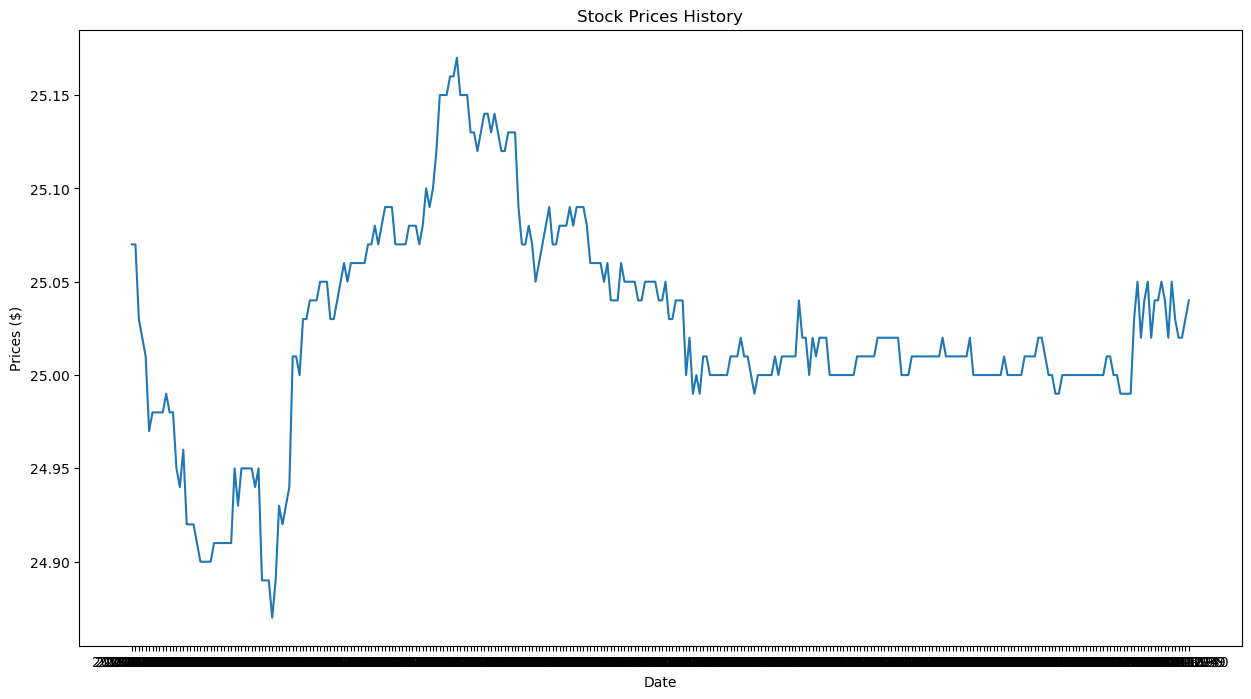

In [7]:
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



df = pd.read_csv("data.csv")
df=df[df['fund_symbol']=='AAA']
df.set_index("price_date", inplace=True)
df.dropna(inplace=True)


plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')



In [12]:
stock_data=df
stock_data.head()

,fund_symbol,open,high,low,close,adj_close,volume
price_date,,,,,,,
2020-09-09,AAA,25.10,25.12,25.07,25.07,24.85,17300
2020-09-10,AAA,25.06,25.07,25.05,25.07,24.85,23500
2020-09-11,AAA,25.04,25.05,25.02,25.03,24.81,33400
2020-09-14,AAA,25.01,25.06,25.01,25.02,24.80,13100
2020-09-15,AAA,25.02,25.03,25.01,25.01,24.79,12100


In [13]:
close_prices = stock_data['close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

2022-10-25 21:46:23.106523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
188/188 [==============================] - 15s 49ms/step - loss: 0.0093
Epoch 2/3
188/188 [==============================] - 9s 50ms/step - loss: 0.0053
Epoch 3/3
188/188 [==============================] - 9s 48ms/step - loss: 0.0036


In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2/2 [==============================] - 2s 73ms/step


0.004922380755024606

/var/folders/86/h1jldhvn2c1d559td_1jddnr0000gn/T/ipykernel_48527/2587210512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


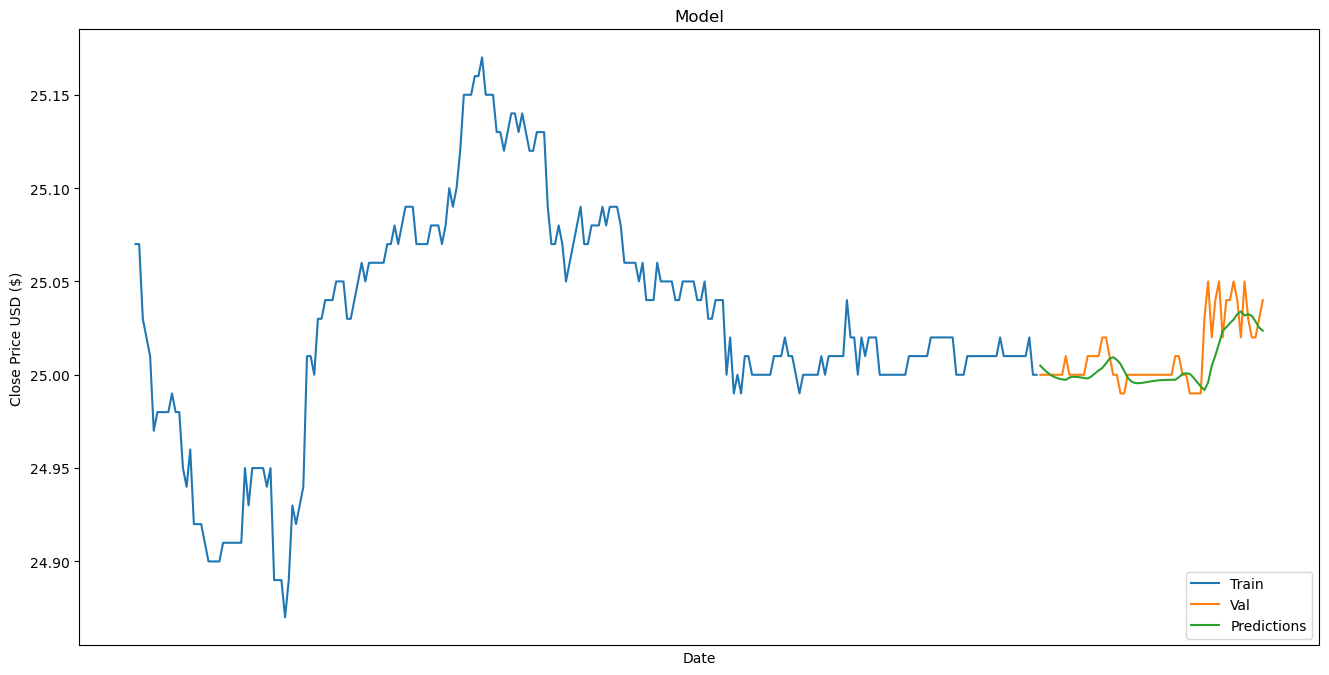

In [26]:

data = stock_data.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.xticks([])
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from matplotlib.widgets import Slider

from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import mean_absolute_error as mae
df_Metrics = pd.DataFrame(columns=['model'])
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

mae_score=mae(y_test, predictions)
smape=0
fore=np.mean(y_test-predictions)
quan= 0
df_Metrics = df_Metrics[df_Metrics['model'] != "LSTM"]
df_Metrics=df_Metrics.append({'model': 'LSTM',
                   'MAE': mae_score,
                   'RMSE':rmse,
                   'sMAPE':smape,
                   'FORECAST ERROR':fore,
                   'QUANTILE ERROR':quan
                  }, ignore_index=True)
#metrics={'RF', mae, rsme,smape,fore,quan,precision,recall,f1,roc,accuracy}
#df_Metrics.insert('RF', mae, rsme,smape,fore,quan,precision,recall,f1,roc,accuracy)

2/2 [==============================] - 0s 67ms/step


In [30]:
df_Metrics.head()


,model,FORECAST ERROR,MAE,QUANTILE ERROR,RMSE,sMAPE
0,LSTM,0.004922,0.008934,0.0,0.004922,0.0
